In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
data = pd.read_csv('../input/imdb_master.csv',encoding="latin-1")

In [ ]:
data.sample(4)

In [ ]:
import nltk

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
def tokenize(texts):
    result = []
    for text in tqdm_notebook(texts):
        tokens = nltk.tokenize.word_tokenize(text.lower())
        result.append(tokens)
    return result

In [ ]:
tokenized = tokenize(data.review)

In [ ]:
print(len(tokenized))
print(tokenized[0])

In [ ]:
import itertools
from collections import Counter

In [ ]:
word_counts = Counter(itertools.chain(*tokenized))

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset

In [ ]:
eos_token = '</EOS>'
pad_token = '<PAD>'
unk_token = '<UNK>'
sos_token = '<SOS>'
# mask_token = '<MASK>'

In [ ]:
class VocabLike:
    def __init__(self, itos, unk_index):
        self._itos = itos
        self._stoi = {word:i for i, word in enumerate(itos)}
        self._unk_index = unk_index
        
    def __len__(self):
        return len(self._itos)
    
    def word2id(self, word):
        idx = self._stoi.get(word)
        if idx is not None:
            return idx
        return self._unk_index
    
    def id2word(self, idx):
        return self._itos[idx]

In [ ]:
def make_vocab(counts:Counter, max_words, specials, unk_index):
    index = 0
    itos = [x for x in specials]
    for w, c in counts.most_common(max_words):
        itos.append(w)
        
    return VocabLike(itos, unk_index)

In [ ]:
def to_numeric_indices(text, vocab: VocabLike, start_token=None, end_token=None):
    result = []
#     print(text)
    if start_token:
        result.append(vocab.word2id(start_token))
    result.extend(vocab.word2id(tok) for tok in text)
    if end_token:
        result.append(vocab.word2id(end_token))
    return result

In [ ]:
def texts_to_numeric(texts, vocab, start_token=None, end_token=None):
    return [to_numeric_indices(t,vocab, start_token, end_token) for t in texts]

In [135]:
def texts_to_tensor(texts, pad_index, max_size, forward_padding=False):
    batch_size = len(texts)
#     print('batch size', batch_size)
    result = torch.zeros(batch_size, max_size, dtype=torch.long)
    result += pad_index
    for i, text in enumerate(texts):
        size = min(max_size, len(text))
        if forward_padding:
            result[i,-size:] = torch.tensor(text)[:size]
        else:
            result[i,:size] = torch.tensor(text)[:size]
        
    return result

In [ ]:
vocab = make_vocab(word_counts, max_words=20000, specials=(unk_token,pad_token, sos_token, eos_token), unk_index=0)

In [ ]:
unk_index, pad_index, sos_index, eos_index = [vocab.word2id(t) for t in 
                                                          (unk_token,pad_token, sos_token, eos_token)]

In [ ]:
text_tensor = texts_to_tensor(texts_to_numeric(tokenized, vocab, sos_token, eos_token), pad_index, max_size=230)

In [ ]:
print(len(vocab))

In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
lm_ds = TensorDataset(text_tensor)

In [ ]:
def masking_experiment(mask_value):
    q = torch.tensor([1,4.1,0.6,-2.], requires_grad=True)
    k = torch.tensor([[0.6,3,1,-1],
                     [-3, 3.2, -1., 0],
                     [3.1, 2., 0.9, 4.]], requires_grad=True)
    
    pattern = torch.tensor([9,1,3.])
    scores = torch.matmul(q, k.t())
    scores.retain_grad()
    scores[2:] = mask_value
    print(scores)
    weights = torch.softmax(scores, dim=-1)
    print(weights)
    s = weights.dot(pattern)
    print(s)
    s.backward()
    print('scores_grad', scores.grad)
    print('q_grad', q.grad)
    print('k_grad', k.grad)

In [ ]:
masking_experiment(-1e9)
print('------')
masking_experiment(float('-inf'))

In [87]:
class MultiHeadProjection(nn.Module):
    def __init__(self, emb_size, n_heads):
        super().__init__()
        self.emb_size = emb_size
        self.n_heads = n_heads
        self.proj_size = emb_size // n_heads
        assert emb_size % n_heads == 0
        self.projections = nn.ModuleList(nn.Linear(self.emb_size, self.emb_size) for _ in range(3))
    
    def forward(self, Q, K, V):
        # B x N x C
        # B x N x C ==> B x H x N x (C/H)
#         batch_size = Q.size(0)
        query, key, value = [proj(X).view(X.size(0), X.size(1), self.n_heads, self.proj_size).transpose(1,2)
                             for proj,X in zip(self.projections, (Q,K,V) )]
        return query, key, value

In [ ]:
class MultiHeadSelfProjection(nn.Module):
    def __init__(self, emb_size, n_heads):
        super().__init__()
        self.emb_size = emb_size
        self.n_heads = n_heads
        self.proj_size = emb_size // n_heads
        assert emb_size % n_heads == 0
        self.projection_layer = nn.Linear(self.emb_size, self.emb_size * 3)
    
    def forward(self, X):
        # B x N x C
        batch_size, seq_length = X.size()[:2]
        # B x N x 3 x H x proj
        X = self.projection_layer(X).view(batch_size, seq_length, 3, self.n_heads, self.proj_size)
        query = X[:,:,0].transpose(1,2) # = B x N x H x Dim
        key = X[:,:,1].transpose(1,2)
        value = X[:,:,2].transpose(1,2)
        return query, key, value

In [89]:
def multihead_projection_size_test():
    proj = MultiHeadProjection( 40, 4)
    inp = torch.zeros(16, 7, 40)
    q,k,v = proj(inp, inp, inp)
    print(q.size(), k.size(), v.size(), sep='\n')
    print('--------')
    proj = MultiHeadSelfProjection( 40, 4)
    inp = torch.zeros(16, 7, 40)
    q,k,v = proj(inp)
    print(q.size(), k.size(), v.size(), sep='\n')
    
multihead_projection_size_test()

torch.Size([16, 4, 7, 10])
torch.Size([16, 4, 7, 10])
torch.Size([16, 4, 7, 10])
--------
torch.Size([16, 4, 7, 10])
torch.Size([16, 4, 7, 10])
torch.Size([16, 4, 7, 10])


In [ ]:
import torch.nn.functional as F

In [95]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, emb_size, n_heads):
        super().__init__()
        self.emb_size = emb_size
        self.n_heads = n_heads
        self.proj = MultiHeadProjection(emb_size, n_heads)
        self.scaling = np.sqrt(self.proj.proj_size)
        
    def forward(self, X, mask):
        Q,K,V = self.proj(X,X,X)
        #Q K.T
        # B x H x Q x Dp   @   B x H x Dp x K ==> B x H x Q x K
        scores = torch.matmul(Q,K.transpose(-1,-2)) / self.scaling
        if mask is not None:
            scores = mask(scores)
        
        # B x H x N x N
        weights = F.softmax(scores,dim=-1)
        # # B x H x N x N  @  B x H x N x Dp ==> B x H x N x Dp
        values = torch.matmul(weights, V).transpose(1,2)
        
        batch, seq, heads, dim = values.size()
        values = values.contiguous().view(batch,seq,-1)
        return weights, values
        
        
        

In [ ]:
def self_attention_block_test():
    block = SelfAttentionBlock(40,4)
    inp = torch.zeros(16, 7, 40)
    weights, values = block(inp, None)
    print(weights.size(), values.size(), sep='\n')
    
self_attention_block_test()

In [ ]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, emb_size, hidden_size, n_heads):
        super().__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.attention = SelfAttentionBlock(emb_size, n_heads)
        self.position_wise_mlp = nn.Sequential(
            nn.Linear(emb_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, emb_size)
        )
        self.layer_norm1 = nn.LayerNorm(emb_size)
        self.layer_norm2 = nn.LayerNorm(emb_size)
        
    def forward(self, x, mask):
        weights, att = self.attention(x, mask)
        x = self.layer_norm1(x + att)
        x = self.layer_norm2(x + self.position_wise_mlp(x))
        return x, weights
        

In [ ]:
def decoder_block_test():
    block = TransformerDecoderBlock(40,60,4)
    inp = torch.zeros(16, 7, 40)
    res, _ = block(inp, None)
    print(res.size(), sep='\n')
    
decoder_block_test()

In [ ]:
class LearnedPosEmbedding(nn.Module):
    def __init__(self, max_seq_length, embedding_dim):
        super().__init__()
        self.pos_emb = nn.Embedding(max_seq_length, embedding_dim)
    
    def forward(self, n_timesteps):
        return self.pos_emb.weight[:n_timesteps]

In [ ]:
def pos_emb_test():
    print(LearnedPosEmbedding(10,20)(6))
    
pos_emb_test()

In [92]:
class DiagonalMask(nn.Module):
    def __init__(self, seq_len, value):
        super().__init__()
        self.bool_mask = nn.Parameter(torch.ones(seq_len, seq_len, dtype=torch.uint8), requires_grad=False)
        self.bool_mask[:-1,1:].triu_()
        self.bool_mask[:,0] = 0
        self.bool_mask[-1,:] = 0
        self.value = value
#         print(self.bool_mask)
#         print(self.bool_mask.expand(4,2,seq_len,seq_len))
        
    def forward(self, x):
        # x = B H Q K
        q_size, k_size = x.size(-2), x.size(-1)
        x[self.bool_mask[:q_size,:k_size].expand(x.size())] = self.value
        return x

In [ ]:
class SelfAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, pad_index, max_seq_len,
                 pos_embedding, n_layers, emb_size,
                 hidden_size, n_heads,
                 tie_weights=True, default_mask='default'):
        super().__init__() 
        self.embedding_dim = emb_size
        
        self.max_seq_len = max_seq_len
        self.mask = DiagonalMask(max_seq_len, -1e9) if default_mask == 'default' else default_mask
        
        self.emb = nn.Embedding(vocab_size, self.embedding_dim, pad_index)
        self.pos_emb = pos_embedding
        self.attention_blocks = nn.ModuleList([TransformerDecoderBlock(emb_size, hidden_size, n_heads) for _ in range(n_layers)])
        self.tie_weights = tie_weights
        if not tie_weights:
            self.out_emb = nn.Linear(self.embedding_dim, vocab_size, bias=False)
        else:
            self.out_emb = None
        
    def forward(self, x, mask=None, return_weights=False):
        #x = batch, time
        mask = mask if mask is not None else self.mask
        batch_size, timesteps = x.size()
        x = self.emb(x) + self.pos_emb(timesteps)
        
        weights = [] if return_weights else None
        
        for block in self.attention_blocks:
            x, attn_weights = block(x, mask)
            if return_weights:
                weights.append(attn_weights)
        
        if return_weights:
            return x, weights
        else:
            return x
        #x = batch, time, dim
        
    def scores_for_position(self, output, position):
        # B x C
        output = output[torch.arange(output.size(0)),position]
        if self.tie_weights:
            scores = torch.mm(output, self.emb.weight.t())
        else:
            scores = self.out_emb(scores)
        return scores
        
    def scores(self, output):
        # output B x N x C  * C x V == B x N x V
        if self.tie_weights:
            scores = torch.matmul(output, self.emb.weight.t())
        else:
            scores = self.out_emb(scores)
        return scores
        
        

In [ ]:
# class PositionMask:
#     def __init__(self, positions, seq_len, value):
#         self.positions = positions
#         self.bool_mask = torch.arange(seq_len).expand(positions.size(0),-1) >= positions.view(-1,1)
#         self.value = value
# #         print(self.bool_mask)
# #         print(self.bool_mask.view(positions.size(0),1,1,seq_len).expand(positions.size(0), 2, seq_len, seq_len))

#     def cuda(self):
#         self.bool_mask = self.bool_mask.cuda()
#         return self
    
#     def apply(self, x):
#         # x = B H S S
#         batch,seq = self.bool_mask.size()
#         mask = self.bool_mask.view(batch,1,1,seq)
#         x[mask.expand(x.size())] = self.value
#         return x
    

In [ ]:
from sklearn import metrics

In [ ]:
def train_lm(net, optimizer, criterion, loader,  epochs, n_prints, after_epoch=None):
    device = torch.device('cuda')
    for epoch in tqdm_notebook(range(epochs)):
        net.train()
        total_batches = len(loader)
        print_every = total_batches // n_prints
        running_loss = 0.0
        for iteration, xx in tqdm_notebook(enumerate(loader), total=total_batches):
            optimizer.zero_grad()
            
            batch_size, max_seq_length = xx.size()
#             mask = DiagonalMask(max_seq_length-1,-1e9, device)
            
            xx = xx.cuda()
            
            decoder_input = xx[:,:-1]
            decoder_target = xx[:,1:]
            
#             labels = xx[row_index, positions]
#             xx[row_index, positions] = mask_index
            decoder_output = net(decoder_input)
            #scores: B x N x V
            scores = net.scores(decoder_output)
            
            loss = criterion(scores.view(-1, scores.size(-1)), decoder_target.contiguous().view(-1))
            running_loss = 0.9 * running_loss + 0.1 * loss.item()
            if iteration % print_every == print_every - 1:
                print(f'Epoch {epoch} Iteration {iteration} Loss {running_loss}')

            loss.backward()
            
            optimizer.step()
        if after_epoch:
            after_epoch(epoch)
            

In [ ]:
print(range(9)[3])

In [ ]:
def sample(net, start_text, beam_width, max_len, top_k=None):
    tokens = nltk.tokenize.word_tokenize(start_text)
    num_tokens = len(tokens)
    numbers = to_numeric_indices(tokens, vocab, sos_token, None)
    text_len = len(numbers)
    tensor = texts_to_tensor([numbers for _ in range(beam_width)],pad_index, net.max_seq_len).cuda()
    net.eval()
#     mask = DiagonalMask(229,-1e9, torch.device('cuda'))

    with torch.no_grad():
        for i in range(max_len - num_tokens):
            output = net(tensor, return_weights=False)
            scores = net.scores_for_position(output,text_len-1)
            probs = F.softmax(scores, dim=-1)
            
            if top_k:
                probs, sampling_set = torch.topk(probs,top_k, dim=-1, sorted=False)
                
            cat = torch.distributions.Categorical(probs)
            
            if top_k:
                sampled = sampling_set[torch.arange(beam_width),cat.sample()]
            else:
                sampled = cat.sample()
                
            tensor[:, text_len] = sampled
            text_len += 1
            
    result = []
    for row in tensor:
        tokens = [vocab.id2word(idx) for idx in row[:max_len+2].tolist()]
        result.append(' '.join(tokens))
        
    return result
    

In [ ]:
def print_sample(net, start_text, beam_width, max_len, top_k=None):
    for s in sample(net, start_text, beam_width, max_len, top_k):
        print(s)

In [129]:

def save_sample(filename, epoch):
    topk_samples = [(1,1), (5,5), (20,5), (40,10), (None,10)]
    sentences = [sample(net,'', beam_width,30, top) for top, beam_width in topk_samples]
#     sentences = [sample(net,'',1,30,1),
#                  sample(net,'',5 ,30,5),
#                  sample(net,'',5 ,30, 20),
#                  sample(net,'',5 ,30, 40),
#                  sample(net,'',5 ,30,None)]
    with open(filename, 'a+') as f:
        f.write('Epoch {}\n'.format(epoch+1))
        for sents, (topk,_) in zip(sentences, topk_samples):
            f.write('Top-{} sampling\n'.format(topk))
            for sent in sents:
                f.write(sent)
                f.write('\n')
        f.write('=========\n\n')

In [142]:
net = SelfAttentionDecoder(vocab_size=len(vocab),pad_index=pad_index, max_seq_len=229, pos_embedding=LearnedPosEmbedding(229,400),
                           n_layers=4,emb_size=400,hidden_size=1000,n_heads=4,tie_weights=True)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(text_tensor,batch_size=32,shuffle=True)
train_lm(net, optimizer, criterion, train_loader,25,5, after_epoch=lambda e: save_sample('samples_epochs.txt', e))

KeyboardInterrupt: 

In [ ]:
def categorical_test():
    probs = torch.tensor([[0.1,0.9],a[0.9,0.1]])
    cat = torch.distributions.Categorical(probs)
    print(cat.sample())
categorical_test()

In [140]:
print_sample(net, 'i love', 6, 30,30)
print_sample(net, 'he is', 6, 30)
print_sample(net, 'i don\'t', 6, 30)
print_sample(net, 'a great', 6, 30)

<SOS> i love the `` <UNK> ! '' and i am not after watching `` the first movie . '' . i 've got so much of the show , but <PAD>
<SOS> i love 's movie , but i had a few actors did n't like the tv documentary , the rest of the same time and there was no money to <PAD>
<SOS> i love this movie and i 'm very disappointed but it did n't want to see some sort of the actors that has to see what i have no <UNK> <PAD>
<SOS> i love `` horror '' . if i would like this movie on . but that i was still looking for a movie . my first was so bad . <PAD>
<SOS> i love this movie and i was really surprised by a wonderful movie . i can remember how to the <UNK> of the movie i am very entertaining , and <PAD>
<SOS> i love films i can say that i had a big fan of her husband who were looking for the first time . this one is still a horror movie <PAD>
<SOS> he is just very government , which he plays so much like the capture only positive for weekend . he ... somehow , in fact that his cardboard loser 2 <PAD>
<

In [100]:
torch.save(net.state_dict(),'lm')
torch.save(optimizer.state_dict(), 'opt')
torch.save(vocab, 'vocab')
# net = SelfAttentionDecoder(len(vocab.itos),pad_index, LearnedPosEmbedding(230,400),n_layers=4,emb_size=400,hidden_size=1000,n_heads=4,tie_weights=True)
# net = net.cuda()
# optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
# net.load_state_dict(torch.load('lm'))
# optimizer.load_state_dict(torch.load('opt'))

In [103]:
import matplotlib.pyplot as plt

(228, 400)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 228 samples in 0.002s...
[t-SNE] Computed neighbors for 228 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 228 / 228
[t-SNE] Mean sigma: 4.587812
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.276314
[t-SNE] KL divergence after 1000 iterations: 1.865735


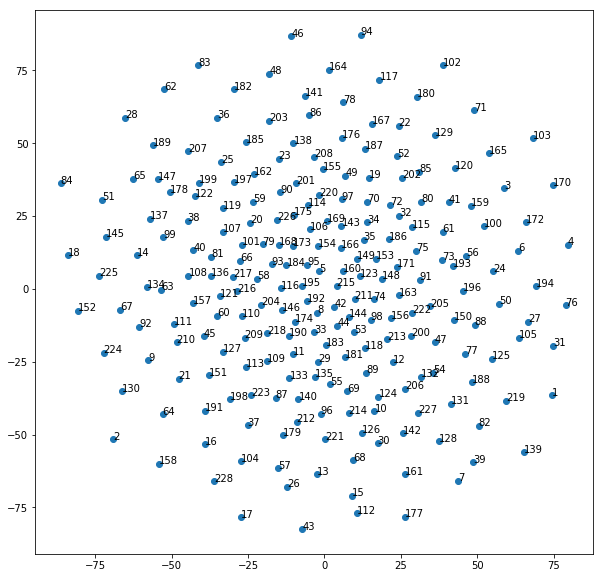

In [104]:
from sklearn import decomposition, manifold

def visualize_positional_embeddings(net):
    pos_embeddings = net.pos_emb.pos_emb.weight.data.cpu().numpy()[:-1]
    print(pos_embeddings.shape)
    tsne = manifold.TSNE(n_components=2,verbose=1)
    proj = tsne.fit_transform(pos_embeddings)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot('111')
    ax.scatter(proj[:,0], proj[:,1])
    for i,(x,y) in enumerate(proj):
        ax.annotate(str(i+1), (x,y))
    
visualize_positional_embeddings(net)

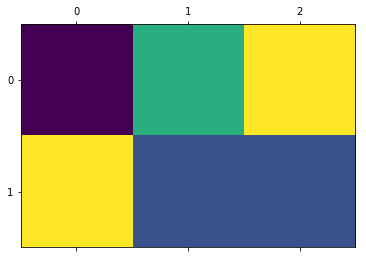

In [107]:
def matshow_test():
    mtr = np.array([[2,7,10],[10,4,4]])
    plt.matshow(mtr)
    plt.show()
matshow_test()

In [122]:
def show_attention_weights(net, text, shift=True):
    net.eval()
    tokens = nltk.tokenize.word_tokenize(text)
    num_tokens = len(tokens)
    numbers = to_numeric_indices(tokens, vocab, sos_token, None)
    text_len = len(numbers)
    tensor = texts_to_tensor([numbers],pad_index, 229)
#     mask = DiagonalMask(229,-1e9, torch.device('cuda'))
    with torch.no_grad():
        _, weights = net(tensor.cuda(), return_weights=True)
    for l, w in enumerate(weights):
        w = w.squeeze(dim=0)
        for h, hw in enumerate(w):
#             print(hw)
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot('111')
            ax.matshow(hw[:text_len+1,:text_len + 1].cpu(),cmap=plt.cm.gray)
            ax.set_xticks(np.arange(text_len+1))
            ax.set_xticklabels([vocab.id2word(idx) for idx in tensor[0,:text_len+1]])
#             ax.set_xticks(np.arange(text_len+1))
            if shift:
                ax.set_yticks(np.arange(text_len))
                ax.set_yticklabels([vocab.id2word(idx) for idx in tensor[0,1:text_len+2]])
            else:
                ax.set_yticks(np.arange(text_len+1))
                ax.set_yticklabels([vocab.id2word(idx) for idx in tensor[0,:text_len+1]])

            ax.set_title('Layer {} Head {}'.format(l+1, h+1))
            plt.show()
    
# show_attention_weights(net, 'the plot is terrible, the actors are great')

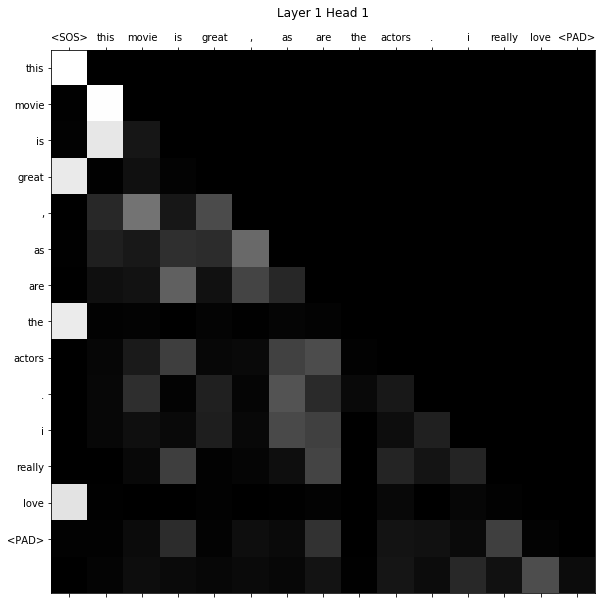

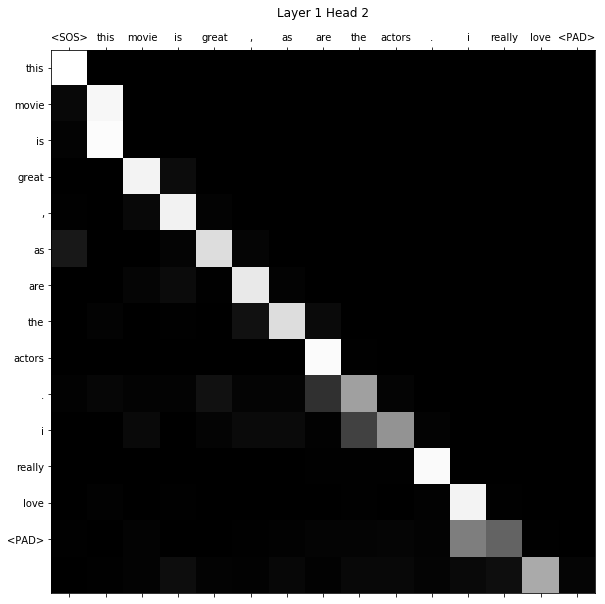

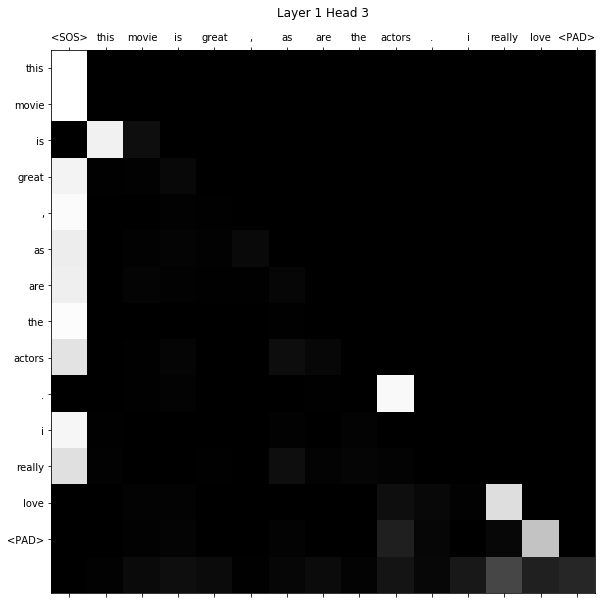

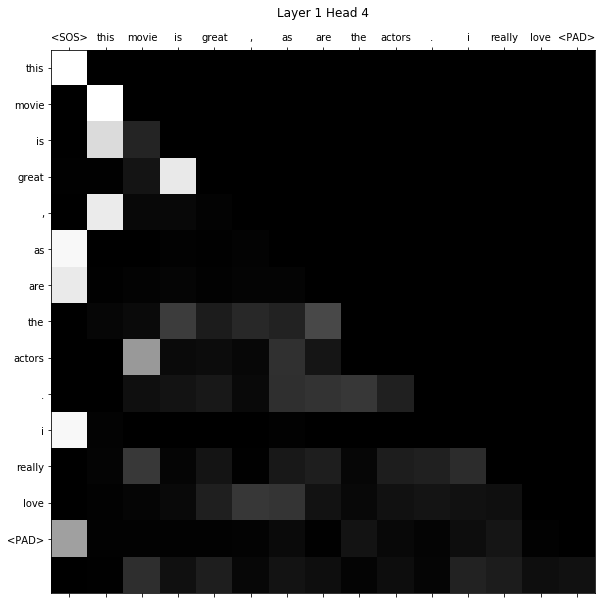

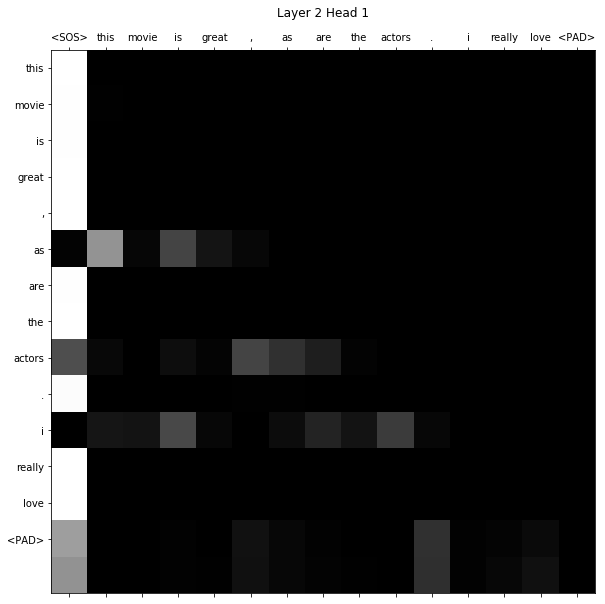

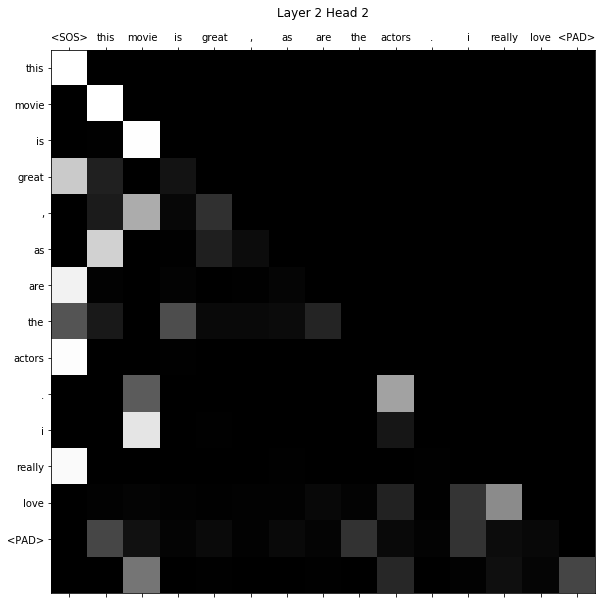

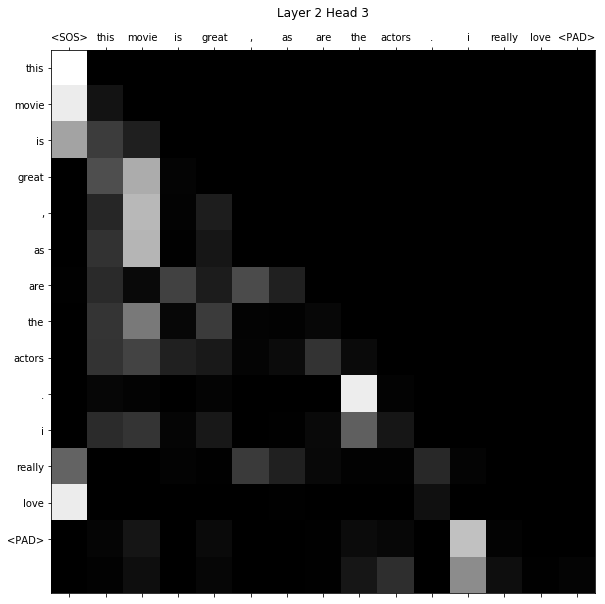

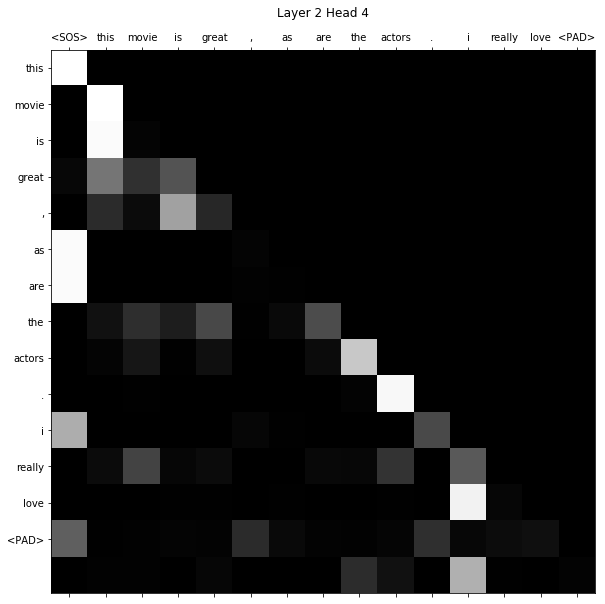

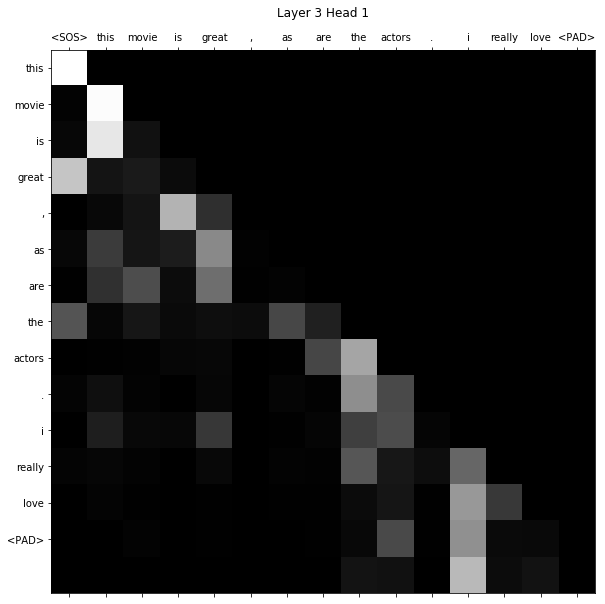

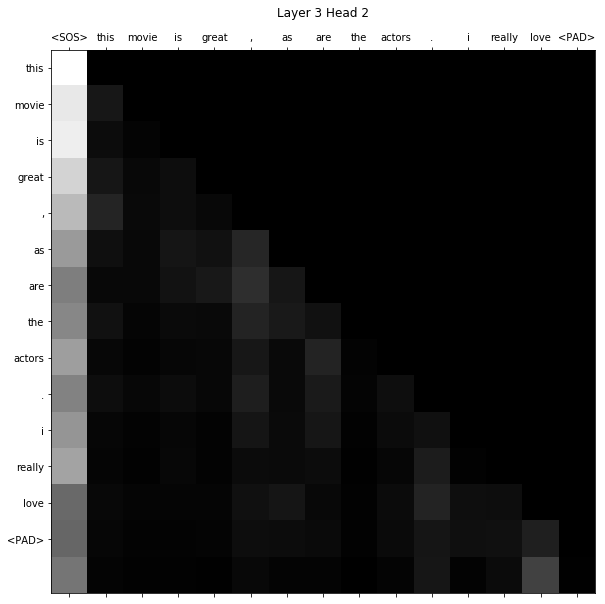

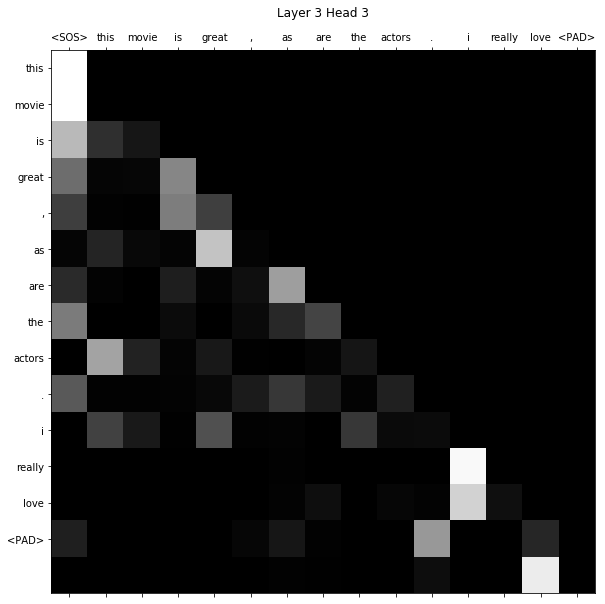

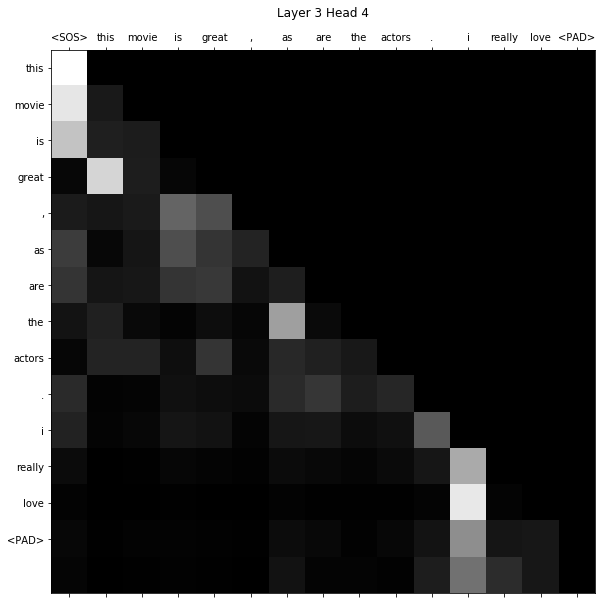

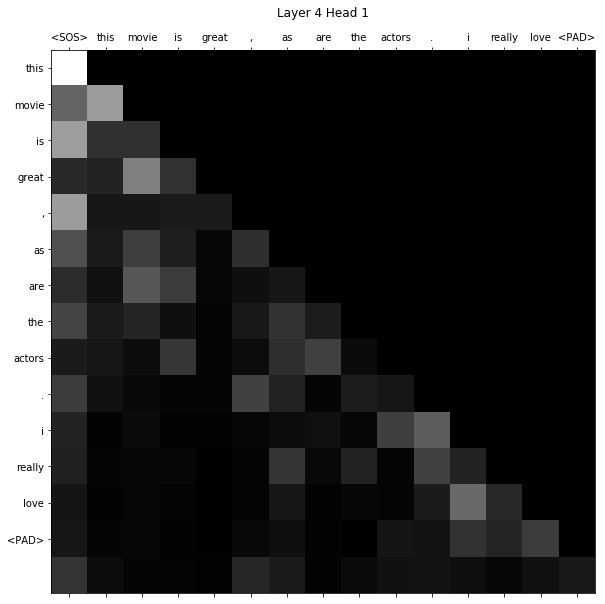

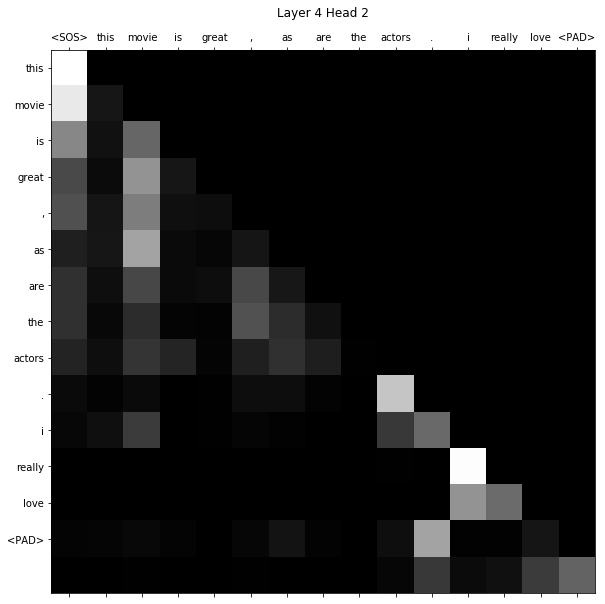

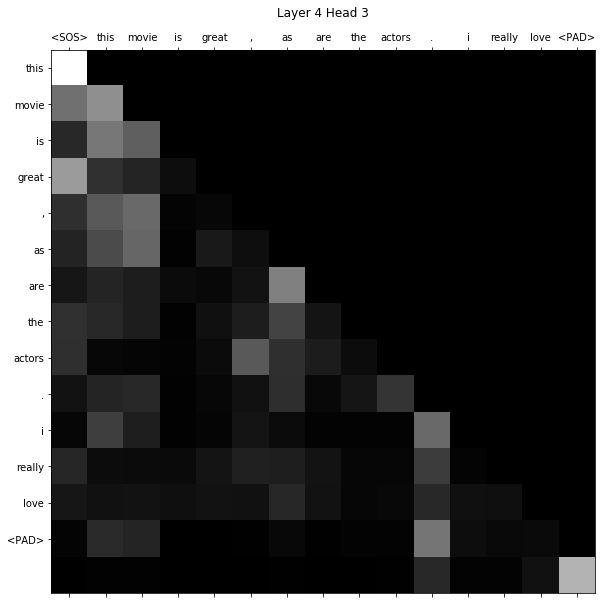

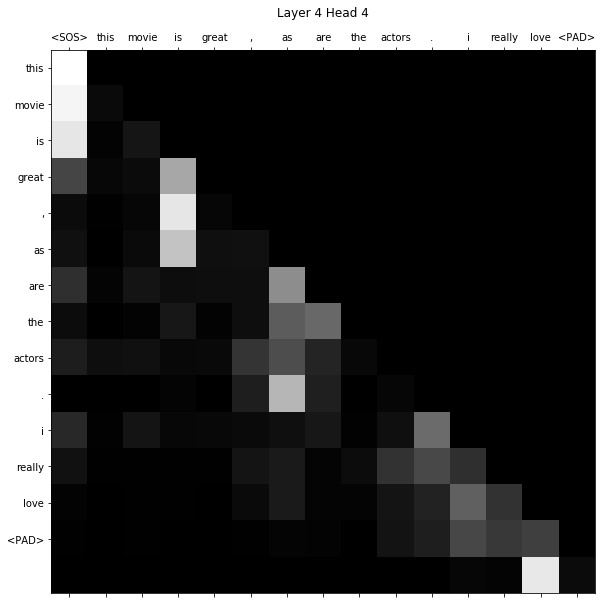

In [124]:
show_attention_weights(net, 'this movie is great, as are the actors. i really love', shift=True)